# Bulk sequencing mapping

Notebook containing pipeline for calling mutations in lambda-sorted highly defective populations. Data graphed here as well.

Modification to original pipeline. Using a shallow-depth dataset generated orthogonally (RNA onwards, so seperate reverse-transcription, amplification, and tagmentation reactions) in order to call deletions. Still collate all deletions across all samples such that any biological replicate called "counts", but only retain those for that purpose that were repeated across true technical duplicates (shallow and deep).

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
scripts = 'Scripts'
import seaborn as sns
import glob

sys.path.append(scripts)
import fastQHandling
import BLASTanalysis
import DeletionAnalysis
import scipy
import numpy as np
import math

from scipy import stats
from statsmodels.stats import multitest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import IFrame    
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

#Superdirectory containing fastq files for all experiments
sequenceDirectory = "Sequencing/lambdaBulkSort"
#Shallow-depth sequencing used to validate deletions
shallowDirectory = "Sequencing/lambdaBulkSortShallow"
#links to precompiled STAR indices
genome = 'Database/WSN_star'
#fasta file for influenza genome
WSNfasta = 'Database/WSN_vRNA.fa'
#precompiled blast database for WSN_vRNA
WSNblastdb = 'Database/WSN_BLAST/WSN_vRNA'
#list of pcr adapters for trimming
adapterFile = 'Database/adapter.fa'

#Results
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
#blast variables for identifying junctions
percentIdentity = 90
wordSize = 10
gapOpen = 5
gapExtend = 2
eValue = 0.000001
outFormat = '"6 qseqid qlen qstart qend sstart send evalue sseqid qseq"'


#multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
#some parameters for plotting

figureDirectory = 'Figures/'
if not os.path.isdir(figureDirectory):
    os.mkdir(figureDirectory)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 16, 'axes.titlesize':'medium',})
sns.set_style("white")
sns.set_style("ticks")
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
segments = ['PB2_vRNA', 'PB1_vRNA', 'PA_vRNA','HA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

## Mapping

Similar to the pipeline used in Mendes and Russell 2022, but less rigorous and use BLAST mapping alone (but use ungapped mapping for SNPs)



In [2]:
experiments = []
for file in glob.glob(sequenceDirectory + '/*.fastq*'):
    fileName = file.split('/')[-1]
    descriptors = fileName.split('_')
    biologicalReplicate = descriptors[0]
    technicalReplicate = descriptors[1]
    interferonState = descriptors[2]
    read = descriptors[-2]
    #for this paper, currently only 1 run per experiment, but might as well add some flexibility.
    sequencingRun = '_'.join(descriptors[3:5])
    experiments += [pd.DataFrame({'biological_replicate':[biologicalReplicate],
                                 'technical_replicate':[technicalReplicate], 'experimental_condition':[interferonState],
                                  'read_pair':[read], 
                                  'file_name':[file], 'sequencing_run':[sequencingRun]})]
experiments = pd.concat(experiments).reset_index().drop(columns=['index'])
unique = experiments.groupby([ 'biological_replicate', 'technical_replicate', 'experimental_condition']).file_name.apply(list).reset_index()
experiments.set_index(['biological_replicate','technical_replicate', 'experimental_condition'])

read_pair  \
biological_replicate technical_replicate experimental_condition             
1                    1                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     2                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     3                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
2                    1                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     2                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   
                     3                   negative                      R1   
                                         negative                      R2   
                                         positive                      R1   
                                         positive                      R2   

                                                                                                         file_name  \
biological_replicate technical_replicate experimental_condition                                                      
1                    1                   negative                Sequencing/lambdaBulkSort/1_1_negative_S22_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_1_negative_S22_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_1_positive_S21_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_1_positive_S21_L00...   
                     2                   negative                Sequencing/lambdaBulkSort/1_2_negative_S24_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_2_negative_S24_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_2_positive_S23_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_2_positive_S23_L00...   
                     3                   negative                Sequencing/lambdaBulkSort/1_3_negative_S26_L00...   
                                         negative                Sequencing/lambdaBulkSort/1_3_negative_S26_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_3_positive_S25_L00...   
                                         positive                Sequencing/lambdaBulkSort/1_3_positive_S25_L00...   
2                    1                   negative                Sequencing/lambdaBulkSort/2_1_negative_S28_L00...   
                                         negative                Sequencing/lambdaBulkSort/2_1_negative_S28_L00...   
                                         positive                Sequencing/lambdaBulkSort/2_1_positive_S27_L00...   
                                         positive      

Quality metrics on sequencing run.

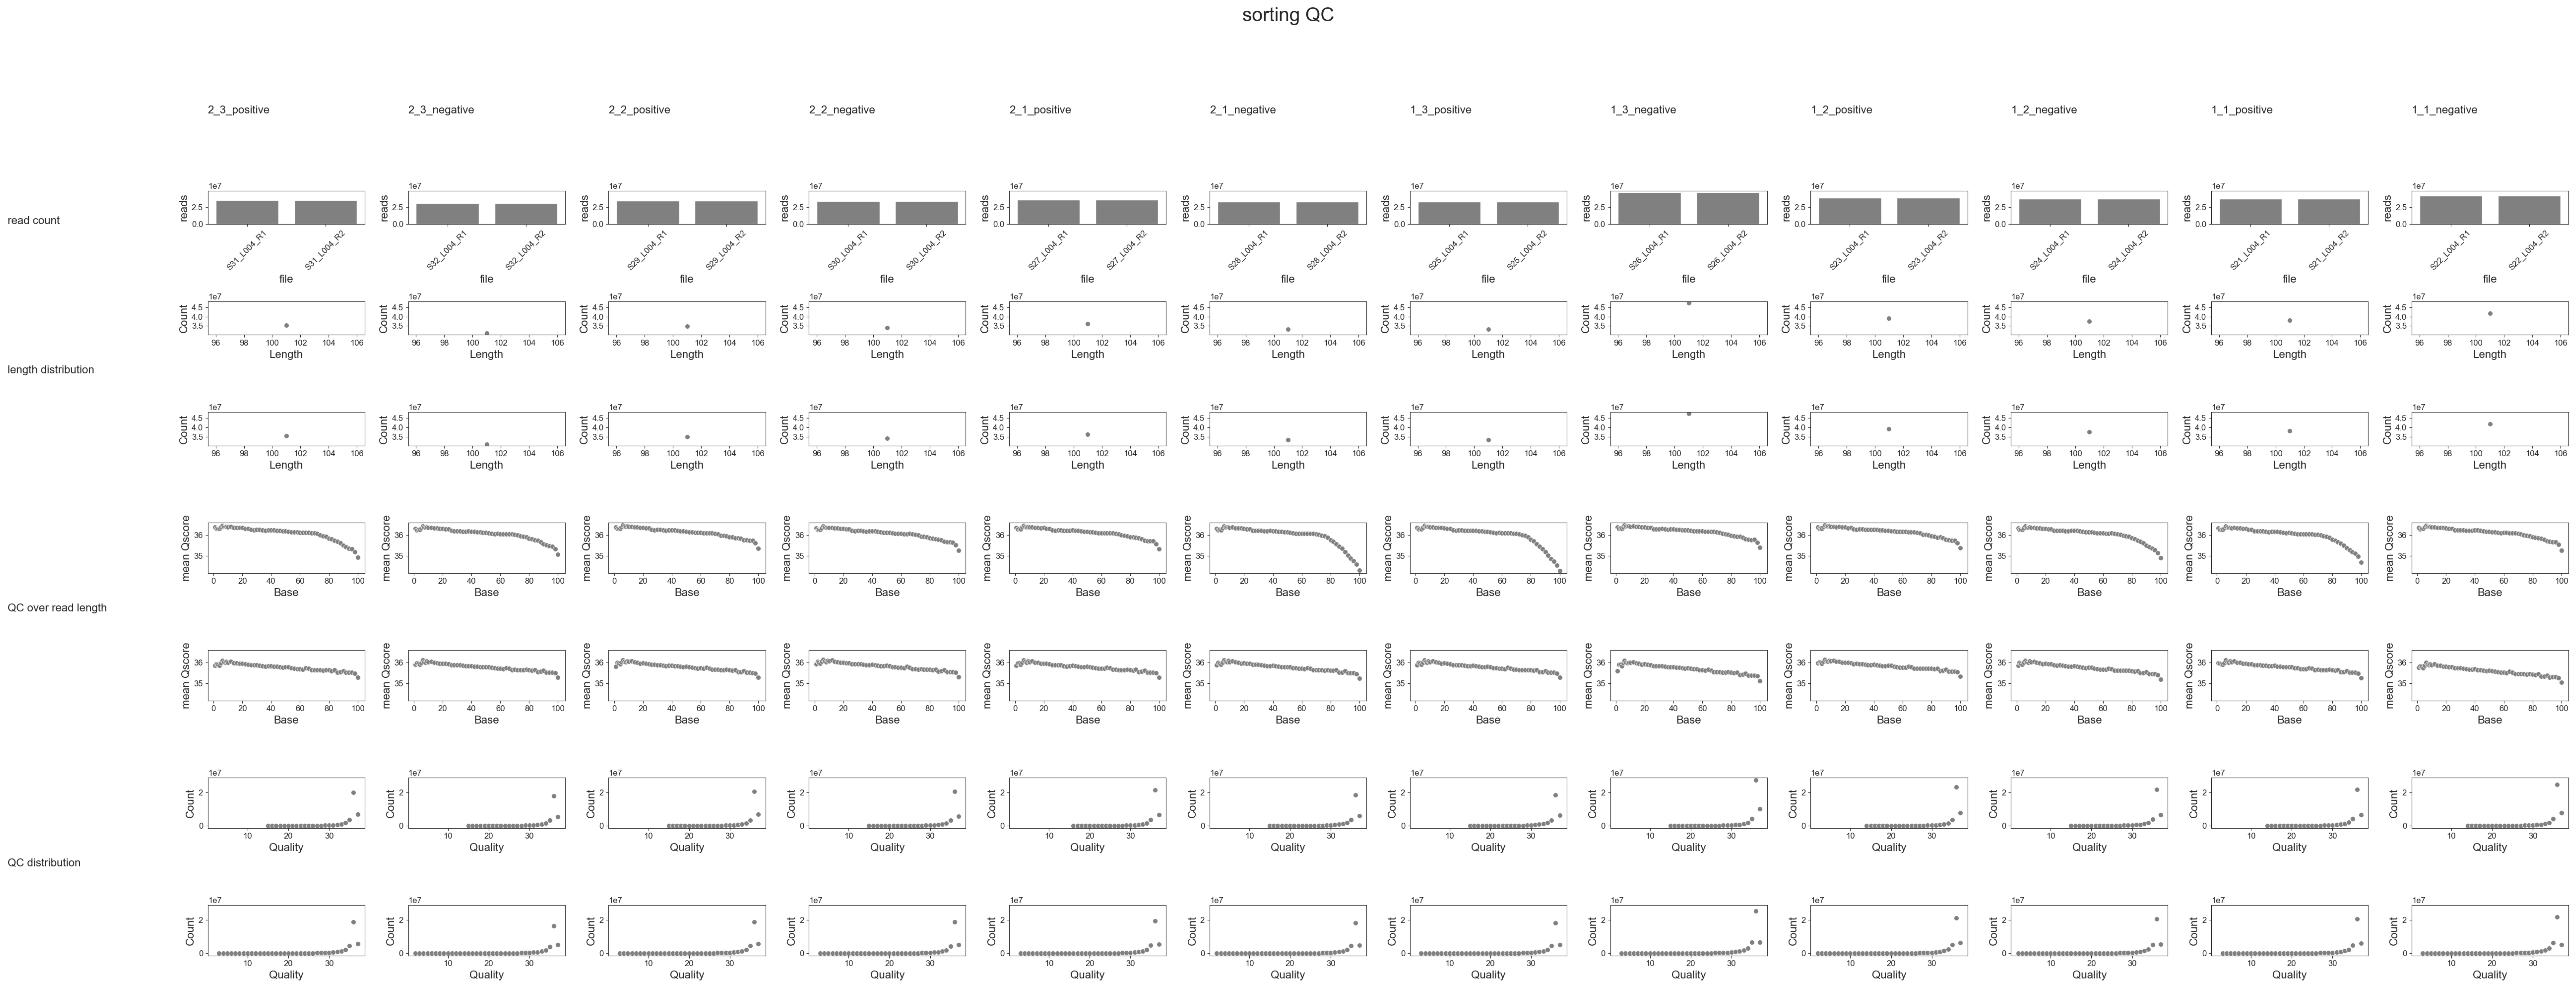

In [88]:
def fastQC(tupleArgument):
    sampleName = tupleArgument[0]
    reads = tupleArgument[1]
    return {sampleName:fastQHandling.fastQCreport(sampleName=sampleName, reads=reads)}
figsDisplay = []
reports = []
results = {}
samples = {}
for index, row in experiments.iterrows():
    sample = '_'.join([str(row.biological_replicate), str(row.technical_replicate), row.experimental_condition])
    read = row.file_name
    readName = row.sequencing_run + '_' + row.read_pair
    if sample not in samples.keys():
        samples[sample] = {readName:read}
    else:
        samples[sample][readName] = read
popList = [(sample, samples[sample]) for sample in list(samples.keys())]
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        reports += p.map(fastQC, [popList.pop() for i in range(numProcessors) if len(popList) != 0])
reports = {key:value for dictionary in reports for key, value in dictionary.items()} 
a = fastQHandling.graphAllTheThings(data=reports, title='sorting QC')
#pdf for publication
plt.savefig(sequenceDirectory + '/sequenceQC.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(sequenceDirectory + '/sequenceQC.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [sequenceDirectory + '/sequenceQC.png']
width = 128 * len(figsDisplay)
g = plt.figure(1, (width, 128))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Processed with trimmomatic.

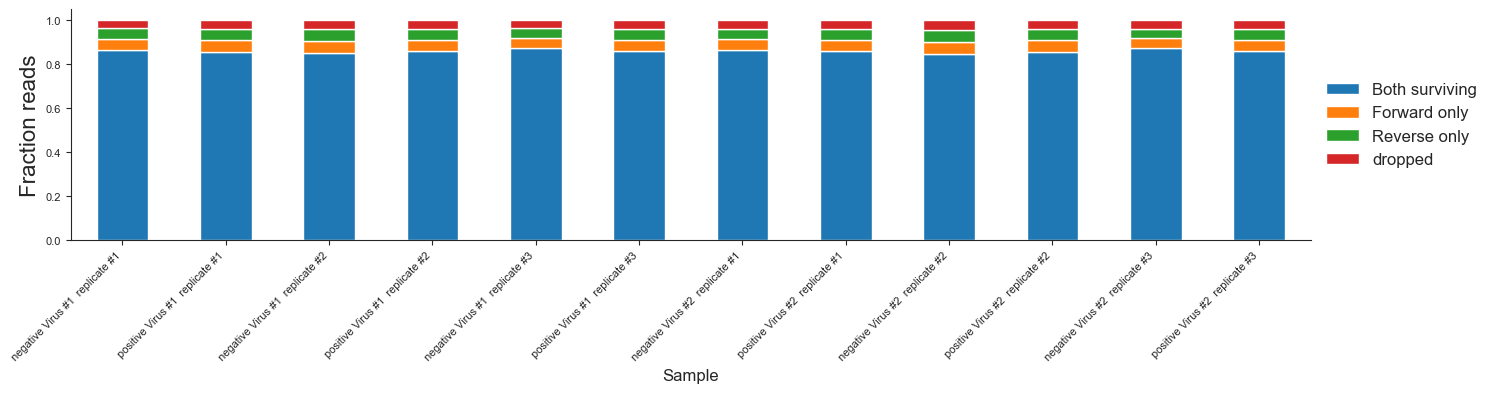

In [89]:
#list comprehension to get reports on trimming statistics. Using baseline recommendations of program creators.
#Can overwrite if need be. Does not rerun if already run in past, only grabs statistics. Pass rerun=True, if overwrite
#is desired.
if not os.path.isdir('/'.join([sequenceDirectory, 'trimmed_reads'])):
    os.mkdir('/'.join([sequenceDirectory, 'trimmed_reads']))
rows = experiments.groupby([ 'biological_replicate', 'technical_replicate', 'experimental_condition','sequencing_run']).file_name.apply(list).reset_index().iterrows()
stats = pd.concat([fastQHandling.trimCommandPaired(read1=row[1].file_name[0], 
                           read2= row[1].file_name[1],
                           outDirectory='/'.join([sequenceDirectory, 'trimmed_reads']),
                            adapterFile= adapterFile,
                            sampleName = ''.join([row[1].experimental_condition + ' Virus #',str(row[1].biological_replicate) + ' ',' replicate #', str(row[1].technical_replicate)]),
                          threads = numProcessors) for row in rows]).set_index('Sample')
#return raw numbers from above as they are generally more useful, but go ahead and collapse to percentages here
stats=stats.div(stats['Input read pairs'], axis=0).drop(columns=['Input read pairs'])
ax = stats.loc[:,['Both surviving', 'Forward only', 'Reverse only', 'dropped']].plot.bar(stacked=True,figsize=(16,3), fontsize=8)
sns.despine()
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Fraction reads', fontsize=16)
plt.savefig(sequenceDirectory + '/trimming_statistics.pdf', format='pdf', bbox_inches = "tight")

Initial STAR mapping to identify contiguously mapping reads.

In [3]:

for index, row in experiments.groupby(['biological_replicate', 'technical_replicate', 'experimental_condition']).file_name.apply(list).reset_index().iterrows():
    #making sure pipeline supports multiple sequencing runs.
    condition = row.experimental_condition
    bio_replicate = row.biological_replicate
    tech_replicate = row.technical_replicate
    sequences = experiments[(experiments.biological_replicate == bio_replicate) & (experiments.technical_replicate == tech_replicate) & (
                            experiments.experimental_condition == condition)]
    outDirectory = resultsDir + '/STARalign'
    if not os.path.isdir(outDirectory):
        os.mkdir(outDirectory)
    #collate all R1s and associated R2s. ORDER CRITICAL, hence the whole song and dance here
    R1 = []
    R2 = []
    for index, row in sequences[sequences.read_pair == 'R1'].iterrows():
        read1 = row.file_name
        read2 = sequences[(sequences.sequencing_run == row.sequencing_run) & (
                sequences.read_pair == 'R2')].file_name.iloc[0]
        R1 += ['/'.join(read1.split('/')[:-1]) + '/trimmed_reads/' +read1.split('/')[-1]]
        R2 += ['/'.join(read2.split('/')[:-1]) + '/trimmed_reads/' +read2.split('/')[-1]]
    outprefix = outDirectory + '/' + 'Virus-' + str(bio_replicate) + '-' + str(tech_replicate) + '_' + condition + '_' 
    for read in R1 + R2:
        unzipped = read[:-3]
        !gunzip -c $read > $unzipped
    read1unzip = ','.join([read[:-3] for read in R1])
    read2unzip = ','.join([read[:-3] for read in R2])
    outprefix1 = outprefix + '_R1_'
    outprefix2 = outprefix + '_R2_'
    logFile1 =  outprefix1 + 'terminal.txt'
    logFile2 =  outprefix2 + 'terminal.txt'
    capture1 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read1unzip --outFileNamePrefix $outprefix1 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx
    capture2 = !STAR --runMode alignReads --runThreadN $numProcessors --genomeDir $genome --readFilesIn $read2unzip --outFileNamePrefix $outprefix2 --outSAMtype BAM Unsorted   --alignSJoverhangMin 1000  --outFilterMismatchNmax 3 --scoreDelOpen -6 --scoreDelBase -6 --alignEndsType EndToEnd --outReadsUnmapped Fastx

    with open(logFile1, 'w') as outfile1, open(logFile2, 'w') as outfile2:
        for line in capture1:
            outfile1.write(line + '\n')
        for line in capture2:
            outfile2.write(line + '\n')

    for read in R1 + R2:
        unzipped = read[:-3]
        !rm -f $unzipped

Mapping metrics for first run.

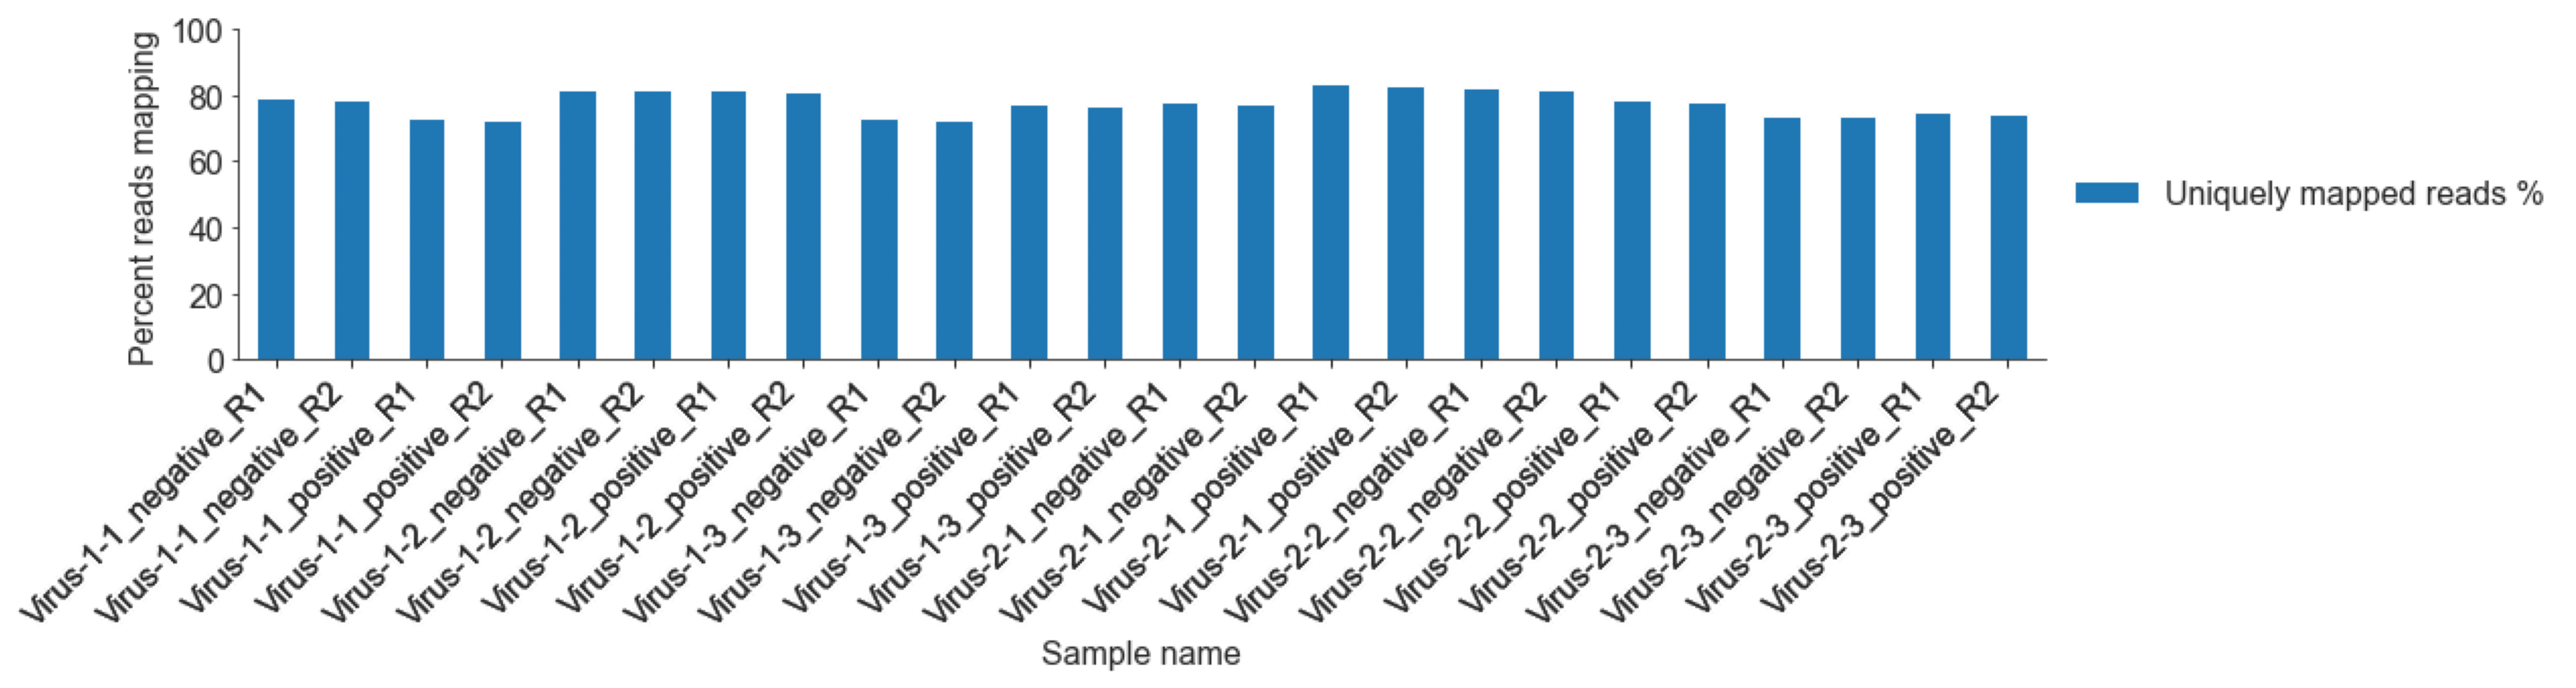

In [4]:
figsDisplay = []
reads = ['R1', 'R2']
data = []
for index, row in experiments.iterrows():
    for read in reads:
        sampleName = 'Virus-' + \
               str(row.biological_replicate) + '-' + \
               str(row.technical_replicate) + '_' + \
               row.experimental_condition 
        filename = resultsDir + '/STARalign/' + sampleName + '_'  + '_' + read + '_Log.final.out'
        sampleName = sampleName + '_' + read
        data += [fastQHandling.STARreport(filename,sampleName)]

data = pd.concat(data)
data.loc[:,['Uniquely mapped reads %','Sample name']].set_index('Sample name').plot.bar(stacked=True,figsize=(16,3), fontsize=16)
sns.despine()
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xticks(rotation=45,horizontalalignment="right")
plt.ylabel('Percent reads mapping', fontsize=16)
plt.ylim(0,100)
plt.savefig(resultsDir + '/STARalign/alignment.pdf', format='pdf', bbox_inches = "tight")
#png for showing here
plt.savefig(resultsDir + '/STARalign/alignment.png', format='png', bbox_inches = "tight")
plt.close()
figsDisplay += [resultsDir + '/STARalign/alignment.png']
width = 64 * len(figsDisplay)
g = plt.figure(1, (width, 32))
spec = g.add_gridspec(ncols= len(figsDisplay),nrows=1)
for column, fig in enumerate(figsDisplay):
    ax = g.add_subplot(spec[0,column])
    img=mpimg.imread(fig)
    ax.imshow(img)
    ax.axis('off')

Pull unmapped reads, convert to FASTA for BLAST analysis.

In [5]:
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    read1 = directory + sampleName + '__R1_Unmapped.out.mate1'
    read2 = directory + sampleName + '__R2_Unmapped.out.mate1'
    outfile = directory + sampleName + '_vRNA_Unmapped.fasta'
    !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read1 > $outfile
    !awk '{{if(NR%4==1) {{printf(">%s\n",substr($$0,2));}} else if(NR%4==2) print;}}' $read2 >> $outfile

BLAST mapping of unmapped reads against WSN genome.

In [6]:
samples = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    outdirectory = resultsDir + '/BLASTresults/'
    if not os.path.isdir(outdirectory):
        os.mkdir(outdirectory)
    outfile = outdirectory + sampleName +'.blastout'
    infile = directory + sampleName + '_vRNA_Unmapped.fasta'
    arguments = ' '.join(['-db', WSNblastdb, '-query', infile, '-perc_identity', str(percentIdentity), 
                         '-num_threads', str(numProcessors), '-word_size', str(wordSize), '-gapopen', str(gapOpen),
                         '-gapextend', str(gapExtend), '-evalue', str(eValue), '-outfmt', outFormat,
                         '-out', outfile])
    !blastn $arguments
    
    samples += [outfile] 
#seperate loop as my code isn't parallelizable within samples, so just go ahead and parallelize samples themselves
def junctionAnalysis(sample):
    BLASTanalysis.delMap(sample, sample[:-(len('.blastout'))] + '_junctions.tsv', WSNfasta)


while len(samples) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(junctionAnalysis, [samples.pop() for i in range(numProcessors) if len(samples) != 0] )

read-name annotated file of deletions

In [154]:
samples = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    directory = resultsDir + '/STARalign/'
    outdirectory = resultsDir + '/BLASTresults/'
    outfile = outdirectory + sampleName +'.blastout'    
    samples += [outfile] 
#seperate loop as my code isn't parallelizable within samples, so just go ahead and parallelize samples themselves
def junctionAnalysis(sample):
    BLASTanalysis.delAnnotate(sample, sample[:-(len('.blastout'))] + '_annotated_junctions.tsv', WSNfasta)
while len(samples) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(junctionAnalysis, [samples.pop() for i in range(numProcessors) if len(samples) != 0] )

Combine bamfiles from R1 and R2 for final alignment. 

In [158]:
if not os.path.isdir(resultsDir + '/finalAlign/'):
    os.mkdir(resultsDir + '/finalAlign/')
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    outbase = resultsDir + '/finalAlign/' + sampleName
    firstAlignBase = resultsDir + '/STARalign/' + sampleName
    b1_1 = firstAlignBase + '__R1_Aligned.out.bam'
    b1_2 = firstAlignBase + '__R2_Aligned.out.bam'
    tempBam = outbase + '_temp.bam'
    finBam = outbase + '.bam'
    possortBam = outbase + '_position.bam'
    extraCores = numProcessors - 1
    cap = !samtools merge -@ $extraCores $finBam $b1_1 $b1_2 
    cap = !samtools sort -n -@ $extraCores -o $tempBam $finBam
    cap = !samtools fixmate -p -@ $extraCores $tempBam $finBam
    cap = !rm -f $tempBam
    cap = !samtools sort -@ $extraCores -o $possortBam $finBam
    !samtools index $possortBam

Total fragments for FPM conversions. Only consider paired mappings. Will need to add from BLAST deletions after de-duplicating for others to get real FPM.

Useful for SNP as well as might as well leave out reads with known junctions.

In [159]:
outputDir = 'Results/totalFragments/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)
def totalFrag(arguments):
    bamfile = arguments[0]
    numbers = []
    for segment in segments:
        command = f"samtools view -f 0x1 -F 0x900 {bamfile} {segment}"
        command += " | awk '{if($9 != 0) {print $0}}' | wc -l"
        process = subprocess.Popen(command, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        #using float as should always be an int, this is just a little check for me
        number = (float(stdout.decode('utf-8')))/float(2)
        numbers += [pd.DataFrame({'segment':[segment], "fragments":[number]})]
    pd.concat(numbers).to_csv(arguments[1], sep='\t')
    

popList = []
for index, row in unique.iterrows():
    sampleName = 'Virus-' + \
           str(row.biological_replicate) + '-' + \
           str(row.technical_replicate) + '_' + \
           row.experimental_condition 
    bamfile = resultsDir + '/finalAlign/' + sampleName + '_position.bam'
    outfile = outputDir + sampleName + '_totalFragments.tsv'
    popList.append((bamfile, outfile))
    
while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(totalFrag, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )

Per/position SNP data.

In [160]:
def rawSeqMaps(arguments):
    DeletionAnalysis.positionalData(sortedBamfile = arguments[0],outfile=arguments[1],
                               qvalCutoff=arguments[2])


popList = []
if not os.path.isdir(resultsDir + '/SNPcounts/'):
    os.mkdir(resultsDir + '/SNPcounts/')
for index, row in unique.iterrows():
    outDirectory = resultsDir + '/SNPcounts/'
    sampleName = 'Virus-' +            str(row.biological_replicate) + '-' +            str(row.technical_replicate) + '_' +            row.experimental_condition
    junctionFile = resultsDir + '/junctionData/Virus-' + str(row.biological_replicate) + '/threshold_intron.tsv'
    bamfile = resultsDir + '/finalAlign/' + sampleName + '.bam'
    outfile = outDirectory + sampleName + '_SNP.tsv'
    popList.append((bamfile, outfile, 30))

while len(popList) > 0:
    with Pool(processes = numProcessors) as p:
        output = p.map(rawSeqMaps, [popList.pop() for i in range(numProcessors) if len(popList) != 0] )

Generate summarized deletion data, de-duplicating reads. Technically reads with multiple deletions would count multiple times, which is a bit annoying but makes sense with FPM data as they would contribute two deletions.

Deletions therefore must be represented by two reads overlapping with same deletion identified by BLAST, else the other read, present in the STAR file, must not be incongrous with the blast deletion (ie it must map to the same segment, and, it may not map to a region overlapping the deletion).


In [12]:
finalDir = 'Results/DeletionCounts'
if not os.path.isdir(finalDir):
    os.mkdir(finalDir)

    
def CIGARmapped(row):
    CIGAR = row.CIGAR
    mappedLen = 0
    currString = ''
    for character in CIGAR:
        if not character.isalpha():
            currString += character
        else:
            if (character == 'M') | (character == 'N') | (character == 'D'):
                mappedLen += int(currString)
            currString = ''
    return mappedLen

    
for index, row in unique.iterrows():
    sampleName = 'Virus-' + str(row.biological_replicate) + '-' + str(row.technical_replicate) + '_' + row.experimental_condition
    inBLAST = resultsDir + '/BLASTresults/' + sampleName + '_annotated_junctions.tsv'
    outFile = finalDir + '/' + sampleName + '_counts.tsv'
    #anything with duplicates automatically is supported
    blastFrame = pd.read_csv(inBLAST, sep='\t', names = ['read', 'segment', 'fivePrime', 'threePrime'])
    dupli = blastFrame[blastFrame.duplicated( keep='first')]
    #now for the remainder
    nonDupli = blastFrame[~blastFrame.duplicated( keep=False)]        
    inBam = resultsDir + '/finalAlign/' + sampleName + '.bam'
    #unpaired
    !samtools view -F 0x1 $inBam  > $tempfile
    #read in as pandas dataFrame. Restrict and ignore optional columns
    unpaired = pd.read_csv(tempfile, sep= '\t', names = ['read','flag','segment','startpos','mapq','CIGAR'], usecols=np.arange(0,6,1))
    #only retain reads present in both datasets, that map to the same segment
    unpaired = nonDupli.merge(unpaired, on = ['read', 'segment'], how = 'inner') 
    #confirm that STAR-mapped read does not preclude BLAST-mapped reads
    unpaired['maplength'] = unpaired.apply(lambda row: CIGARmapped(row), axis = 1)
    #mapped region cannot overlap deleted region. Start of mapping can be after end of deletion, or end of mapping before
    unpaired = unpaired.loc[(unpaired.startpos > unpaired.threePrime) | (unpaired.startpos + unpaired.maplength < unpaired.fivePrime),['segment','read','fivePrime','threePrime']]
    final = pd.concat([dupli, unpaired]).groupby(['segment','fivePrime','threePrime']).count().reset_index().rename(columns={'read':'counts'})
    final.to_csv(outFile, sep = '\t')
    !rm -f $tempFile

# Graphing of Data

Lets just look at per/base error/mutation rate for each position in each segment.

In [168]:
#load in data, annotate
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    frame = pd.read_csv(file, sep='\t')
    virusName = os.path.basename(file).split('_')[0]
    interferonState = os.path.basename(file).split('_')[1]
    techRep = virusName.split('-')[2]
    bioRep = virusName.split('-')[1]
    frame['biologicalReplicate'] = bioRep
    frame['technicalReplicate'] = techRep
    frame['interferonState'] = interferonState
    data += [frame]
data = pd.concat(data)
data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)

def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0

data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)



Averages across all segments.

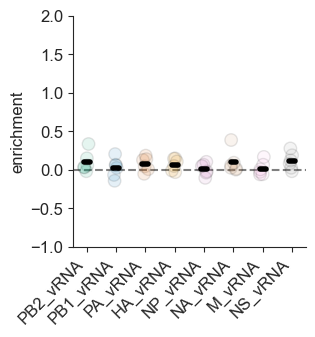

In [169]:


plot = data.pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'segment'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)

fig, ax = plt.subplots(figsize= (3,3))
sns.stripplot(x='segment', y='enrichment', data=plot,  edgecolor='black', order = segments,
            jitter=True, dodge=True, linewidth=1, s=9, palette=fluColors, alpha = 0.1, ax=ax)

sns.despine()
plt.xlabel('')
plt.ylim(-0.5,0.5)
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
plt.ylim(-1,2)
#stats!
pvals = []
corresponding = []
for segment in segments:
    tstat, pval = stats.ttest_1samp(plot[plot.segment == segment].enrichment,0)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    y = plot[plot.segment == segments[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)

In [170]:
NSonly = data.loc[data.segment == 'NS_vRNA',].copy()
NSonly['inactivate'] = 'ignore'


NSonly.loc[(NSonly.position >= 172) & (NSonly.position <= 864), 'segment'] = 'NS1 and NEP'
NSonly.loc[(NSonly.position >= 363) & (NSonly.position <= 834), 'segment'] = 'NS1'





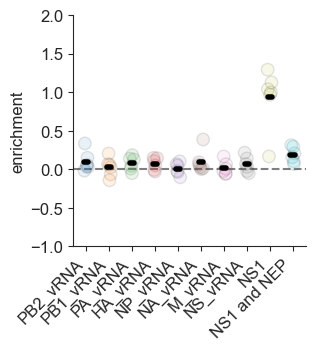

In [171]:

plot = pd.concat([data, NSonly]).pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'segment'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)
fig, ax = plt.subplots(figsize= (3,3))
order = ['PB2_vRNA','PB1_vRNA','PA_vRNA','HA_vRNA','NP_vRNA',
         'NA_vRNA','M_vRNA', 'NS_vRNA',
         'NS1','NS1 and NEP']

sns.stripplot(x='segment', y='enrichment', data=plot,  order=order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            palette=fluColors.update({'NS1':fluColors['NS_vRNA'], 'NS1 and NEP':fluColors['NS_vRNA']}),
            alpha = 0.1, ax=ax)
sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
#stats!
plt.ylim(-1,2)
pvals = []
corresponding = []
for segment in order:
    tstat, pval = stats.ttest_1samp(plot[plot.segment == segment].enrichment,0)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    y = plot[plot.segment == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/meanSNP.pdf')

For main figure, just NS1 and NS1 and NEP

0.0030821962202221033


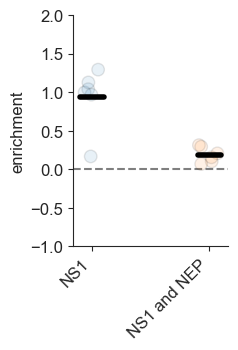

In [172]:
plot = pd.concat([data, NSonly]).pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'segment'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)
fig, ax = plt.subplots(figsize= (2,3))
order = ['NS1','NS1 and NEP']

sns.stripplot(x='segment', y='enrichment', data=plot,  order=order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            palette=fluColors.update({'NS1':fluColors['NS_vRNA'], 'NS1 and NEP':fluColors['NS_vRNA']}),
            alpha = 0.1, ax=ax)
sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
#stats!
plt.ylim(-1,2)
pvals = []
corresponding = []
tstat, pval = stats.ttest_rel(plot[plot.segment == 'NS1'].enrichment,plot[plot.segment == 'NS1 and NEP'].enrichment)
pvals += [pval]
offset = 0
for position, val in enumerate(order):
    y = plot[plot.segment == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/meanSNPNSonly.pdf')
print(str(pval))

now graph

/Users/alistair/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


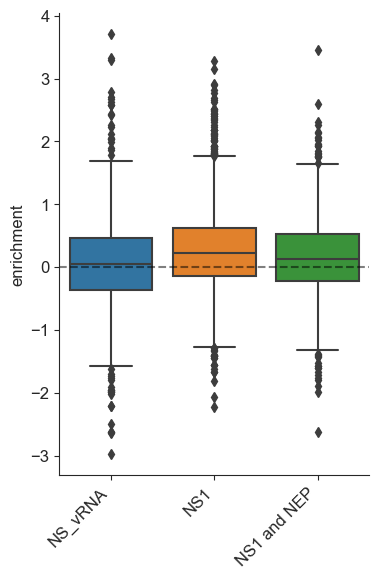

In [173]:
plot = NSonly[NSonly.segment != 'ignore'].groupby(['segment', 'interferonState','technicalReplicate','biologicalReplicate','position']).mean().reset_index()



plot = plot.pivot_table(index=['technicalReplicate', 'biologicalReplicate', 'segment', 'position'], values='minorityFreq', columns = ['interferonState']).reset_index()


plot['enrichment'] = np.log2(plot.positive/plot.negative)
plot = plot[(plot.negative != 0) & (plot.positive !=0)]
fig, ax = plt.subplots(figsize= (4,6))
order = ['NS_vRNA','NS1', 'NS1 and NEP']
sns.boxplot(x='segment', y='enrichment', data=plot,   order = order, ax=ax)

sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)


plt.savefig('Figures/allPosSNP.pdf')

Run an anova, if p<0.05, use Tukey's post-hoc test to compare between groups. Draw in for figure later. Using code is too messy and it is easiest just to draw, but do want to record values in notebook.

In [174]:
stat, pval = scipy.stats.f_oneway( plot[plot.segment == 'NS1'].enrichment, plot[plot.segment == 'NS1 and NEP'].enrichment)
if pval < 0.05:
    tukey = pairwise_tukeyhsd(endog=plot['enrichment'],
                              groups=plot['segment'],
                              alpha=0.05)
    print(tukey)
else:
    print('No significant difference detected by ANOVA at a pvalue of 0.05')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
        NS1 NS1 and NEP   -0.109 0.001 -0.1606 -0.0574   True
        NS1     NS_vRNA  -0.2126 0.001 -0.2661 -0.1592   True
NS1 and NEP     NS_vRNA  -0.1037 0.001 -0.1655 -0.0419   True
-------------------------------------------------------------


Caveat, are NS1 mutations more common? If so (across datasets) then this could be a sensitivity issue.

plotted vs mean frequency at site.

[ True  True]


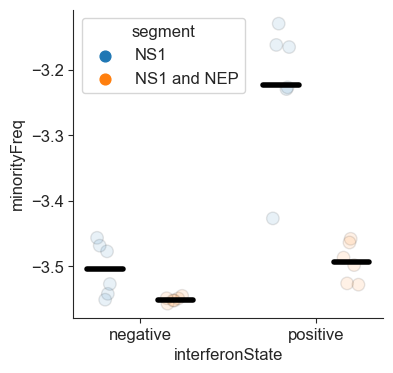

In [176]:
plot = NSonly[NSonly.segment != 'ignore'].groupby(['segment', 'interferonState','technicalReplicate','biologicalReplicate']).mean().reset_index()
plot['minorityFreq'] = np.log10(plot.minorityFreq)
fig, ax = plt.subplots(figsize= (4,4))


hue_order = ['NS1','NS1 and NEP']
order= [ 'negative','positive']
sns.stripplot(x='interferonState', y='minorityFreq', hue='segment', data=plot, order = order,  hue_order=hue_order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            alpha = 0.1, ax=ax)

sns.despine()
pvals = []
for position, condition in enumerate(order):
    tstat, pval = stats.ttest_rel(plot[(plot.segment == 'NS1') & (plot.interferonState == condition)].minorityFreq,
                                  plot[(plot.segment == 'NS1 and NEP') & (plot.interferonState == condition)].minorityFreq)
    pvals += [pval]
    y = plot[(plot.segment == 'NS1') & (plot.interferonState == condition)].minorityFreq.mean()
    plt.plot([position-0.3, position-0.1], [y, y], lw=4, c='k', zorder=8)
    y = plot[(plot.segment == 'NS1 and NEP') & (plot.interferonState == condition)].minorityFreq.mean()
    plt.plot([position+0.1, position+0.3], [y, y], lw=4, c='k', zorder=8)
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]

print(pvals)

What about deletions? First, lets load in data.

In [2]:
data = []
for file in glob.glob('Results/DeletionCounts/*counts.tsv'):
    IFNstate = file.split('_')[-2]
    techRep = file.split('_')[-3].split('-')[-1]
    bioRep = file.split('_')[-3].split('-')[-2]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['biological_replicate'] = bioRep
    currFrame['technical_replicate'] = techRep
    currFrame['interferonState'] = IFNstate
    data += [currFrame]
data = pd.concat(data)

Does the distribution both of total and unique make sense?

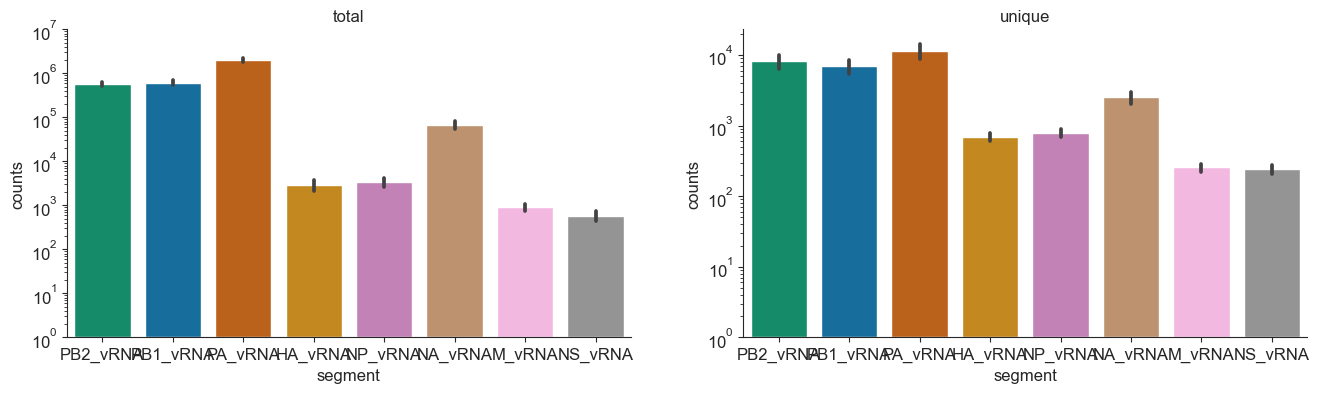

In [3]:
fig,axes = plt.subplots(1,2, figsize=(16,4))

total = data.groupby(['segment', 'technical_replicate', 'biological_replicate', 'interferonState']).sum().reset_index()
sns.barplot(data= total, x='segment', y='counts' ,order= segments, palette=fluColors, ax = axes[0], bottom=1)
sns.despine()
axes[0].set_yscale('log')
axes[0].set_ylim(1,10**7)
axes[0].set_title('total')
unique = data.groupby(['segment', 'technical_replicate', 'biological_replicate', 'interferonState']).count().reset_index()
sns.barplot(data= unique, x='segment', y='counts' ,order= segments, palette=fluColors, ax = axes[1], bottom=1)
sns.despine()
axes[1].set_yscale('log')
axes[1].set_title('unique')
plt.savefig('Figures/totalDeletions.pdf')


Combine datasets, go ahead and add all deletion fragments to total fragment counts and determine FPM

In [4]:

totals = []
for file in glob.glob('Results/totalFragments/*.tsv'):
    IFNstate = file.split('_')[-2]
    techRep = file.split('_')[-3].split('-')[-1]
    bioRep = file.split('_')[-3].split('-')[-2]
    currFrame = pd.read_csv(file, sep='\t')
    currFrame['biological_replicate'] = bioRep
    currFrame['technical_replicate'] = techRep
    currFrame['interferonState'] = IFNstate
    totals += [currFrame]
totals = pd.concat(totals)[['segment','biological_replicate', 'technical_replicate', 'fragments', 'interferonState']]
totals = totals.merge(total, on=['segment','technical_replicate','biological_replicate','interferonState'])
totals = totals[['biological_replicate','technical_replicate','fragments','interferonState','segment']]
data = data.merge(totals)
data['FPM'] = data['counts']/data['fragments'] * 10**6
                

In [5]:
NSonly = data.loc[data.segment == 'NS_vRNA',].copy()


NSonly['segment'] = 'ignore'
NSonly.loc[(NSonly.fivePrime >= 27) &  (NSonly.threePrime <= 864), 'segment'] = 'NS1 and NEP'
NSonly.loc[(NSonly.fivePrime >= 363) & (NSonly.threePrime <= 834), 'segment'] = 'NS1'



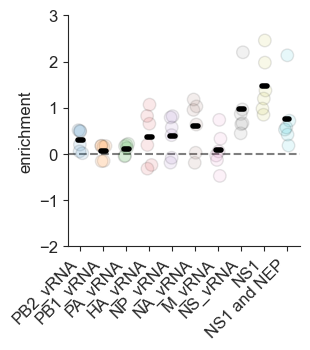

In [14]:
graph = pd.concat([data, NSonly]).groupby(['biological_replicate', 'technical_replicate', 'interferonState','segment']).sum().reset_index().pivot_table(index=['technical_replicate', 'biological_replicate', 'segment'], values='FPM', columns = ['interferonState']).reset_index().dropna()


graph['enrichment'] = np.log2(graph.positive/graph.negative)


fig, ax = plt.subplots(figsize= (3,3))
order = ['PB2_vRNA','PB1_vRNA','PA_vRNA','HA_vRNA','NP_vRNA',
         'NA_vRNA','M_vRNA',  'NS_vRNA',
         'NS1','NS1 and NEP']

sns.stripplot(x='segment', y='enrichment', data=graph,  order=order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            palette=fluColors.update({'NS1':fluColors['NS_vRNA'], 'NS1 and NEP':fluColors['NS_vRNA']}),
            alpha = 0.1, ax=ax)


sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
sns.despine()
plt.ylim(-2,3)
pvals =[]
for segment in order:
    tstat, pval = stats.ttest_1samp(graph[graph.segment == segment].enrichment,0)
    pvals += [pval]
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
offset = 0
for position, val in enumerate(pvals):
    y = graph[graph.segment == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/meanDeletion.pdf')

In [7]:
pvals

array([False, False, False, False, False, False, False, False,  True,
       False])

0.011501204380013213


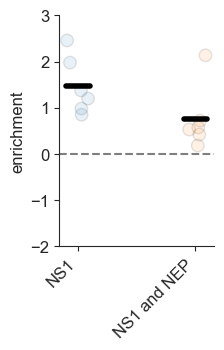

In [8]:
graph = pd.concat([data, NSonly]).groupby(['biological_replicate', 'technical_replicate', 'interferonState','segment']).sum().reset_index().pivot_table(index=['technical_replicate', 'biological_replicate', 'segment'], values='FPM', columns = ['interferonState']).reset_index().dropna()


graph['enrichment'] = np.log2(graph.positive/graph.negative)
fig, ax = plt.subplots(figsize= (2,3))
order = ['NS1','NS1 and NEP']


sns.stripplot(x='segment', y='enrichment', data=graph,  order=order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            palette=fluColors.update({'NS1':fluColors['NS_vRNA'], 'NS1 and NEP':fluColors['NS_vRNA']}),
            alpha = 0.1, ax=ax)

sns.despine()
plt.xlabel('')
a =plt.xticks(rotation=45, ha='right')


plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
#stats!
plt.ylim(-2,3)
pvals = []
corresponding = []
tstat, pval = stats.ttest_rel(graph[graph.segment == 'NS1'].enrichment,graph[graph.segment == 'NS1 and NEP'].enrichment)
pvals += [pval]
offset = 0
for position, val in enumerate(order):
    y = graph[graph.segment == order[position]].enrichment.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/meanDelNSonly.pdf')
print(str(pval))

Compare total (FPM) numbers to see if this is explainable by sensitivity.

[ True  True]


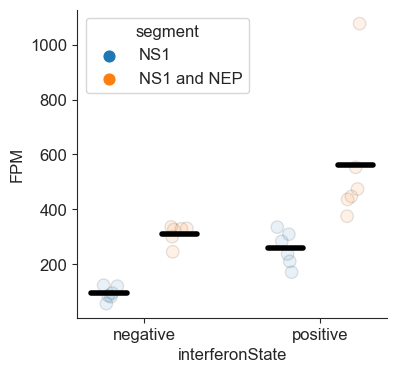

In [15]:
plot = NSonly[NSonly.segment != 'ignore'].groupby(['segment', 'interferonState','technical_replicate','biological_replicate']).sum().reset_index()
fig, ax = plt.subplots(figsize= (4,4))


hue_order = ['NS1','NS1 and NEP']
order= [ 'negative','positive']
sns.stripplot(x='interferonState', y='FPM', hue='segment', data=plot, order = order,  hue_order=hue_order, edgecolor='black', 
            jitter=True, dodge=True, linewidth=1, s=9, 
            alpha = 0.1, ax=ax)

sns.despine()
pvals = []
for position, condition in enumerate(order):
    tstat, pval = stats.ttest_rel(plot[(plot.segment == 'NS1') & (plot.interferonState == condition)].FPM,
                                  plot[(plot.segment == 'NS1 and NEP') & (plot.interferonState == condition)].FPM)
    pvals += [pval]
    y = plot[(plot.segment == 'NS1') & (plot.interferonState == condition)].FPM.mean()
    plt.plot([position-0.3, position-0.1], [y, y], lw=4, c='k', zorder=8)
    y = plot[(plot.segment == 'NS1 and NEP') & (plot.interferonState == condition)].FPM.mean()
    plt.plot([position+0.1, position+0.3], [y, y], lw=4, c='k', zorder=8)
pvals = multitest.multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[0]
plt.savefig('Figures/countsDelSegment.pdf')

print(pvals)

Quick for main figure

pvalue of 0.031159164606882478


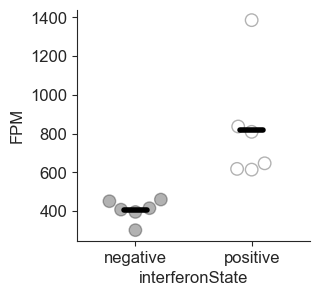

In [186]:
graph = data[data.segment == 'NS_vRNA'].groupby(['biological_replicate', 'technical_replicate', 'interferonState','segment']).sum().reset_index()

fig,ax = plt.subplots(figsize=(3,3))
order = ['negative', 'positive']

sns.swarmplot(y='FPM', x='interferonState', data=graph,
               palette = ['0', '1'], edgecolor='0', dodge=True, linewidth=1, s=9,  ax=ax, alpha=0.3, clip_on=False, order = order)

sns.despine()
tstat, pval = stats.ttest_rel(graph[graph.interferonState == 'positive'].FPM, graph[graph.interferonState == 'negative'].FPM )
print('pvalue of ' + str(pval))

for position, val in enumerate(order):
    y = graph[graph.interferonState == order[position]].FPM.mean()
    plt.plot([position-0.1, position+0.1], [y, y], lw=4, c='k', zorder=8)
plt.savefig('Figures/NSdeletionEnrichment.pdf')